# 1. 손글씨 숫자 데이터셋 심화 실험 (실습 2)

다음 조건에 따라 손글씨 숫자 데이터셋 (sklearn.datasets.load_digits)을 활용해 실험을 수행하고 결과 분석   

> 실습 1 : 학습률 변화에 따른 정확도 비교  
- Adam 옵티마이저를 사용하고, 학습률을 각각 아래에 세 가지로 설정해 모델을 학습
- 0.01, 0,001, 0.0001
- 각 학습률에 대해 최종 정확도를 비교하고, 학습 과정의 loss 또는 accuracy 변화 곡선을 시각화
- 학습률에 따라 정확도가 어떻게 달라지는지 분석

> 실습 2 : 훈련 데이터 축소 후 혼동 행렬 분석  
- train_test_split을 사용해 전체 데이터 중 훈련 데이터의 비율을 50%만 사용해 학습을 진행
- 학습된 모델에 대해 테스트 데이터에 대한 confusion matrix 를 출력하고 시각화
- 오분류된 숫자들이 어떤 것인지 확인하고 그 이유를 분석.


In [28]:
# 1) 라이브러리 임포트
import numpy as np                              # 배열 연산
import matplotlib.pyplot as plt                 # 시각화
import seaborn as sns                           # 고수준 시각화
from sklearn.datasets import load_digits        # 손글씨 숫자 데이터셋
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    # 혼동 행렬 계산

import torch                                    # PyTorch
import torch.nn as nn                           # 신경망 모듈
import torch.optim as optim                     # 최적화 알고리즘
from torch.utils.data import TensorDataset, DataLoader

In [29]:
# 2) 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
# 3) 데이터 로드 및 50% 비율로 train/test 분할
digits = load_digits()
X, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
# train_size=0.5 로 절반만 학습에 사용, 나머지는 테스트
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.5, random_state=2025, stratify=y
)

# 4) NumPy → Tensor 변환 후 Dataset & DataLoader 생성
tr_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
te_ds = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
tr_loader = DataLoader(tr_ds, batch_size=64, shuffle=True)
te_loader = DataLoader(te_ds, batch_size=64, shuffle=False)


In [31]:
# 5) MLP 모델 정의
class DigitNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),  # 64차원 입력 → 128차원 은닉
            nn.ReLU(),           # 비선형 활성화
            nn.Linear(128, 64),  # 128 → 64
            nn.ReLU(),           # 비선형 활성화
            nn.Linear(64, 10)    # 64 → 10개 클래스 출력
        )
    def forward(self, x):
        return self.net(x)


In [32]:
# 6) 학습/평가 함수 정의
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_acc = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_acc  += (logits.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_acc/n

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            total_acc  += (logits.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_acc/n


In [33]:
# 7) 모델 생성, 최적화기 & 손실함수 설정
model     = DigitNet().to(device)              # 모델을 디바이스에 올림
best_lr   = 1e-3                               # 실습1에서 가장 좋았던 lr
optimizer = optim.Adam(model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()              # Softmax + CrossEntropy

metrics = {
    'train_loss': [],
    'train_acc':  [],
    'test_loss':  [],
    'test_acc':   []
}
# 8) 학습 루프
for epoch in range(1, epochs+1):
    # 2-1) 한 epoch 학습
    tr_loss, tr_acc = train_epoch(model, tr_loader, criterion, optimizer, device)
    # 2-2) 한 epoch 평가
    te_loss, te_acc = eval_epoch (model, te_loader, criterion, device)

    # 2-3) 기록
    metrics['train_loss'].append(tr_loss)
    metrics['train_acc' ].append(tr_acc)
    metrics['test_loss' ].append(te_loss)
    metrics['test_acc'  ].append(te_acc)

    # 2-4) 매 10 epoch 마다, 혹은 1 epoch 때 출력
    if epoch == 1 or epoch % 10 == 0:
        print(
            f"[Epoch {epoch:3d}] "
            f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
            f"Test  Loss: {te_loss:.4f}, Test  Acc: {te_acc:.4f}"
        )

# 9) 테스트셋 전체에 대해 예측값 수집
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in te_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

[Epoch   1] Train Loss: 1.8820, Train Acc: 0.4388 | Test  Loss: 1.3135, Test  Acc: 0.7308
[Epoch  10] Train Loss: 0.0931, Train Acc: 0.9800 | Test  Loss: 0.1298, Test  Acc: 0.9588
[Epoch  20] Train Loss: 0.0393, Train Acc: 0.9955 | Test  Loss: 0.0858, Test  Acc: 0.9733
[Epoch  30] Train Loss: 0.0112, Train Acc: 1.0000 | Test  Loss: 0.0725, Test  Acc: 0.9789
[Epoch  40] Train Loss: 0.0073, Train Acc: 1.0000 | Test  Loss: 0.0683, Test  Acc: 0.9800
[Epoch  50] Train Loss: 0.0033, Train Acc: 1.0000 | Test  Loss: 0.0676, Test  Acc: 0.9811
[Epoch  60] Train Loss: 0.0022, Train Acc: 1.0000 | Test  Loss: 0.0704, Test  Acc: 0.9811
[Epoch  70] Train Loss: 0.0017, Train Acc: 1.0000 | Test  Loss: 0.0723, Test  Acc: 0.9800
[Epoch  80] Train Loss: 0.0012, Train Acc: 1.0000 | Test  Loss: 0.0722, Test  Acc: 0.9800
[Epoch  90] Train Loss: 0.0010, Train Acc: 1.0000 | Test  Loss: 0.0752, Test  Acc: 0.9789
[Epoch 100] Train Loss: 0.0007, Train Acc: 1.0000 | Test  Loss: 0.0736, Test  Acc: 0.9789


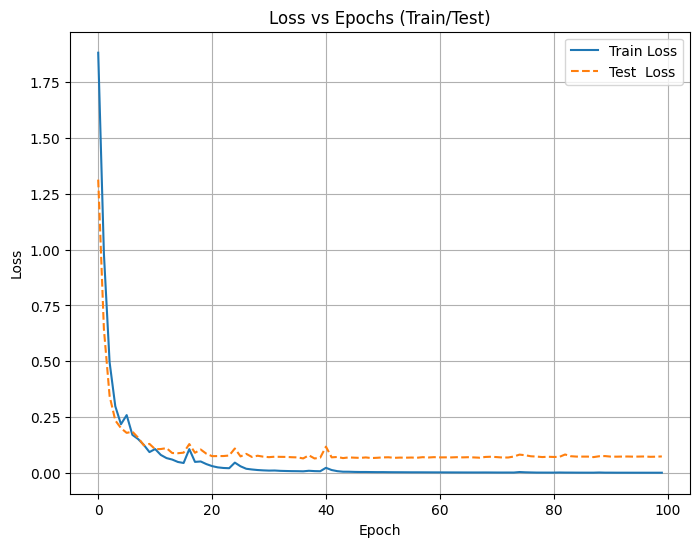

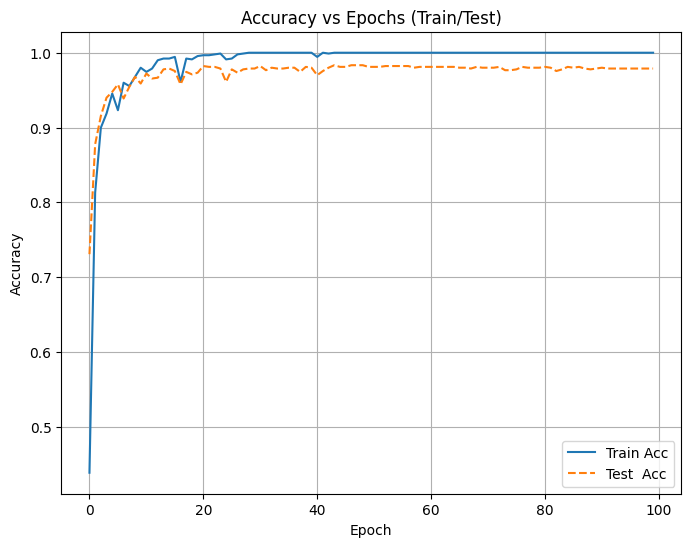

In [34]:

# ——————————————
# 3) Loss 변화 곡선 그리기
plt.figure(figsize=(8,6))
plt.plot(metrics['train_loss'], label='Train Loss')           # 학습 손실
plt.plot(metrics['test_loss'],  '--', label='Test  Loss')     # 테스트 손실 (점선)
plt.title("Loss vs Epochs (Train/Test)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ——————————————
# 4) Accuracy 변화 곡선 그리기
plt.figure(figsize=(8,6))
plt.plot(metrics['train_acc'], label='Train Acc')             # 학습 정확도
plt.plot(metrics['test_acc'],  '--', label='Test  Acc')       # 테스트 정확도 (점선)
plt.title("Accuracy vs Epochs (Train/Test)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

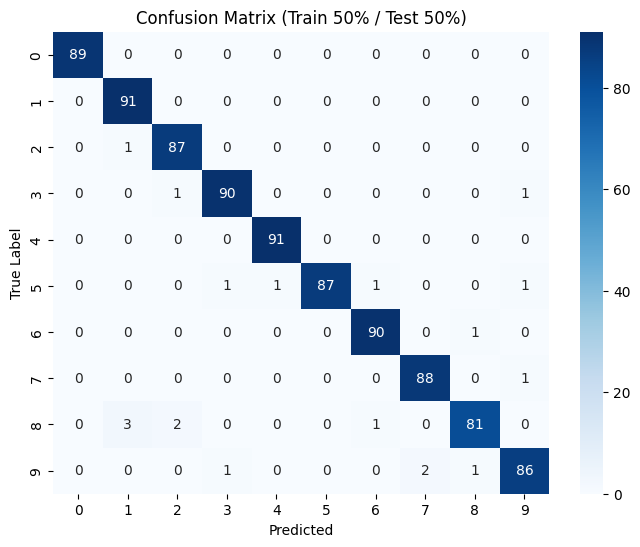

In [35]:
# 10) Confusion Matrix 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Train 50% / Test 50%)")
plt.show()
# 진한 색 : 실제 잘 맞춘 횟수 / 연한 색 : 제대로 못 맞춘 횟수

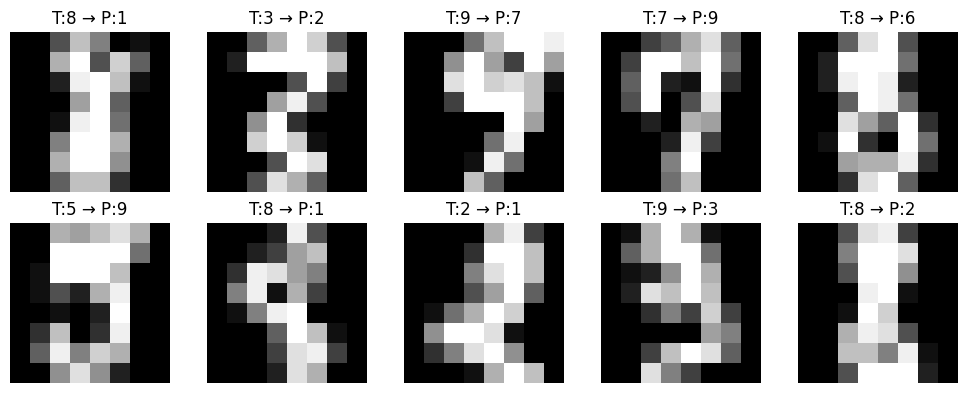

In [36]:
# 11) 오분류 샘플 시각화 (처음 10개)
mis_idx = [i for i,(t,p) in enumerate(zip(all_labels, all_preds)) if t!=p]
plt.figure(figsize=(10,4))
for i, idx in enumerate(mis_idx[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_te[idx].reshape(8,8), cmap='gray')
    plt.title(f"T:{all_labels[idx]} → P:{all_preds[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 결과

- 테스트 정확도가 98.61% (실습 1)에서 97.89% (실습 2) 로 소폭 하락
- 훈련 데이터 절반 감소에 따른 일반화 성능 저하가 관찰됨

### 혼동행렬 해석
- 대각선 (정확 분류) : 전반벅으로 87~91개 클래스 -> 평균 정확도 0.9789
- 주요 오 분류 셀
    - 실제 8 : 예측 1, 3건
    - 실제 8 : 예측 2, 2건
    - 실제 2 : 예측 3, 5, 3, 9, 7 등 1건씩

### 오분류 샘플 분석
- 필기 스타일에 따른 루프의 개방/폐쇄, 획 굵기 및 연결성이 핵심 혼동 요인

### 원인 및 이론적/실무적 고찰
- 데이터 편향성 : 학습 샘플 축소로 인한 대표적 필기 스타일 예시 부족
- 모델 한계 : 단순 MLP가 "공간적 패턴(LOOP)을 충분히 캡처하지 못함
- 손실 함수 민감도 : CrossEntropy만으로는 소수의 혼동 클래스를 별도로 패널티 부여하기 어려움


### 개선 방안
- 데이터 증강 : 랜덤 회전, 스케일 변환 적용해보기
- 오분류 분석 루프 : 혼동이 잦은 샘플을 추가 레이블링 (재학습)

